# SETUP

In [ ]:
# https://towardsdatascience.com/modeling-uncertainty-in-neural-networks-with-tensorflow-probability-391b29538a7a

In [143]:
# Import libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
from sklearn.model_selection import train_test_split

# initiallize tf and tfpl
tfd = tfp.distributions
tfpl = tfp.layers

#LAi example
path = 'C:/Users/nkalimip/Downloads/Estimate_prediction_process/uncertanity_example/information/ABBY_LAI_trainingdata.csv'
df = pd.read_csv(path)
df = df[["B3",  "B4",  "GVI", "NDVI",  "NLI",  "estimateLAI"]]
print(df)

# normallize
from sklearn import preprocessing
import pandas as pd

# d = preprocessing.normalize(df)
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(df)
df = pd.DataFrame(d, columns=df.columns)
print(df)

is_multi =1

if is_multi == 1:
    #Multivariate
    X,y = df[["B3",  "B4",  "GVI", "NDVI",  "NLI"]], df["estimateLAI"]

    y = np.array([[n] for n in y])

    x_train, x_tst, y_train, y_tst = train_test_split(np.array(X), np.array(y), test_size=0.33)
    n_features = x_train.shape[1]
    # print(n_features)
    n_samples = len(X)
    # print(n_samples)
    
if is_multi == 0:
    #Single variate 
    X,y = df["B4"], df["estimateLAI"]

    X = np.array([[n] for n in X])
    y = np.array([[n] for n in y])

    x_train, x_tst, y_train, y_tst = train_test_split(np.array(X), np.array(y), test_size=0.33)
   
    n_features = 1
    n_samples = len(x_train)


    # Plot the data
    plt.figure(figsize=(6, 4))
    plt.scatter(x_train, y_train, alpha=0.05)
    plt.title('Non-linear training data')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.show()


           B3        B4       GVI      NDVI       NLI  estimateLAI
0    0.053457  0.039059  3.138408  0.699875  0.112298  1121.927612
1    0.022062  0.009951  6.067018  0.880014  0.419106  1760.643677
2    0.032734  0.013966  5.497255  0.876757  0.528161  1958.892456
3    0.013409  0.004349  5.305416  0.902152  0.243452  1545.211304
4    0.034889  0.014609  5.892003  0.885449  0.596588  1970.026733
..        ...       ...       ...       ...       ...          ...
610  0.050306  0.044116  3.846089  0.693536  0.147917  1134.339966
611  0.022210  0.008938  4.858061  0.871442  0.308922  1612.877563
612  0.053348  0.027410  4.327738  0.824087  0.493312  1608.857544
613  0.025436  0.011695  6.898124  0.889981  0.550676  2072.858643
614  0.030482  0.015473  4.354428  0.826813  0.265135  1590.002563

[615 rows x 6 columns]
           B3        B4       GVI      NDVI       NLI  estimateLAI
0    0.415778  0.305042  0.302892  0.730510  0.600960     0.523849
1    0.161364  0.075568  0.582730  0.9

# A - Functions

In [144]:

# Prior - diagonal MVN ~ N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    prior_model = tf.keras.Sequential([
        
        tfpl.DistributionLambda(
            # Note: Our prior is a non-trianable distribution
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
    ])
    
    return prior_model


In [145]:

# Posterior
def posterior(kernel_size, bias_size, dtype=None):
    
    n = kernel_size + bias_size
    
    posterior_model = tf.keras.Sequential([
        
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    
    return posterior_model


In [146]:

# Define the model
def get_full_model(x_train_shape,n_features):
    
    model = tf.keras.Sequential([

        # Epistemic uncertainty
        tfpl.DenseVariational(units=20,
                              input_shape=(n_features,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='relu'),
        
        tfpl.DenseVariational(units=10,
                              input_shape=(n_features,),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_weight=1/x_train_shape,
                              kl_use_exact=False,
                              activation='relu'),
        
        tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                              make_prior_fn=prior,
                              make_posterior_fn=posterior,
                              kl_use_exact=False,
                              kl_weight=1/x_train_shape),

        # Aleatoric uncertainty
        tfpl.IndependentNormal(1)
    ])

    def neg_loglik(y_true, y_pred):
        return -y_pred.log_prob(y_true)

    model.compile(loss=neg_loglik, optimizer='rmsprop')
    
    return model


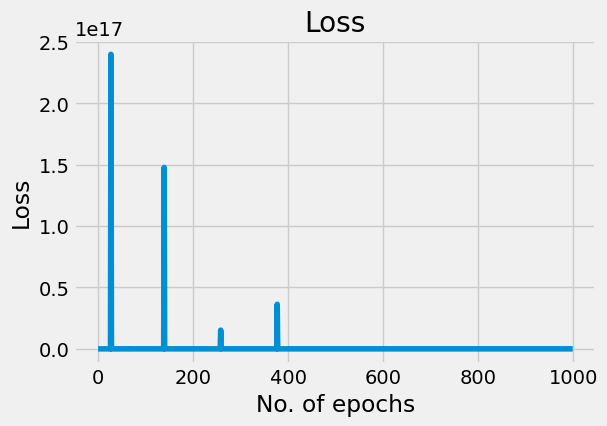

In [147]:

# Get the model
model_full = get_full_model(n_samples,n_features)

# Fit
history = model_full.fit(x_train, y_train, epochs=1000, verbose=0)

# Plot loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.show()


# B -  Training network and Visualization

Text(0.5, 1.0, 'y_train and y_sample')

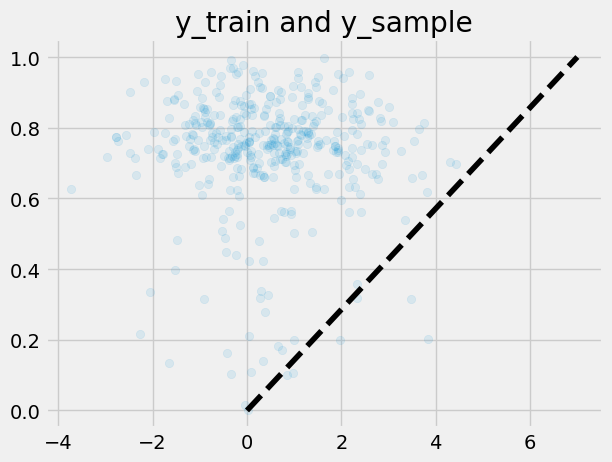

In [141]:
 y_sample = model_full(x_train).sample()
# (print(y_sample))
# print(y_train)

plt.scatter(y_sample, y_train, alpha=.1, label='Training data')
plt.plot([0, 7], [0, 1], 'k--')
plt.title("y_train and y_sample")

Text(0.5, 1.0, 'y_tst and y_sample')

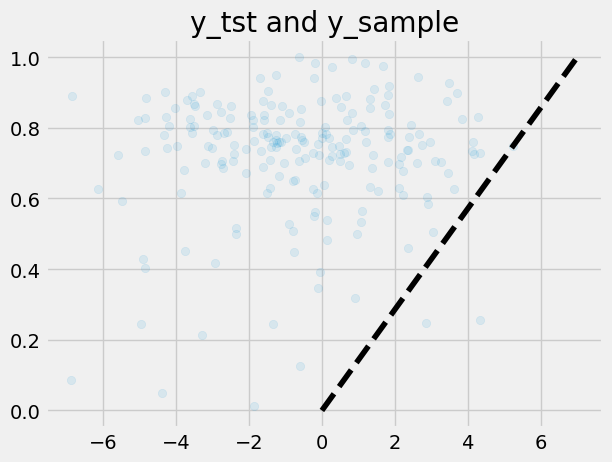

In [142]:
y_sample = model_full(x_tst).sample()
# (print(y_sample))
# print(y_train)
plt.scatter(y_sample, y_tst, alpha=.1, label='Training data')
# plt.plot([0, 0],[ 6,6], linewidth=2)
plt.plot([0, 7], [0, 1], 'k--')
plt.title("y_tst and y_sample")

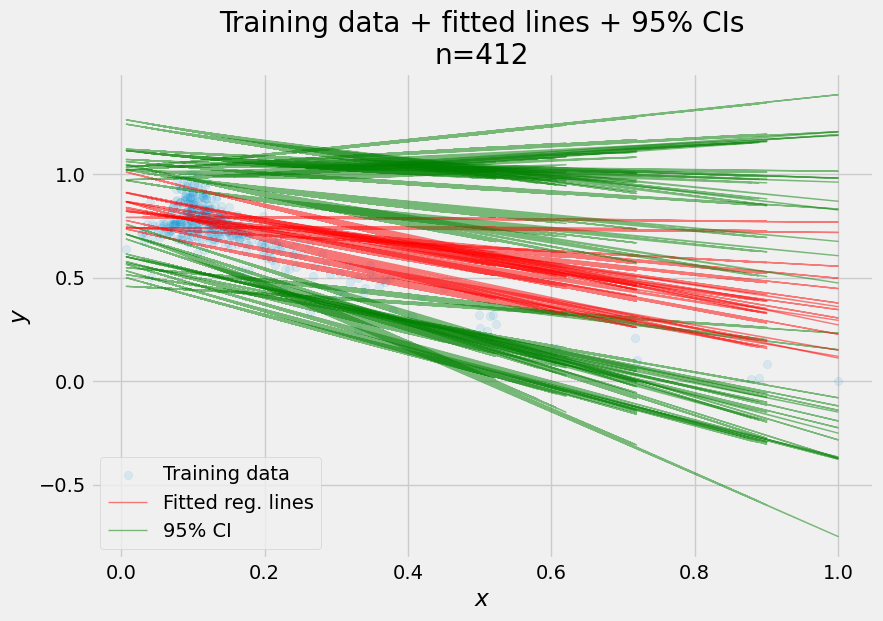

In [111]:
if is_multi == 0:
    # Plot fitted regression lines
    N_ITERS = 15

    plt.figure(figsize=(9, 6))

    # ------------------------------
    # print(model_full(x_train))
    plt.scatter(x_train, y_train, alpha=.1, label='Training data')
    for _ in range(N_ITERS):

        # Compute conf ints
        y_sample = model_full(x_train).sample()
        y_hat = model_full(x_train).mean()

        y_sd = model_full(x_train).stddev()
        y_hat_lower = y_hat - 2 * y_sd
        y_hat_upper = y_hat + 2 * y_sd


        if _ == 0:
            plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1, label='Fitted reg. lines')
            plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1, label='95% CI')
            plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)
        else:
            plt.plot(x_train, y_hat, color='red', alpha=.5, lw=1)    
            plt.plot(x_train, y_hat_lower, c='g', alpha=.5, lw=1)
            plt.plot(x_train, y_hat_upper, c='g', alpha=.5, lw=1)

    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()

    # #------------------------------

    plt.title(f'Training data + fitted lines + 95% CIs\nn={n_samples}')
    plt.show()
